In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os

from tqdm import tqdm
import seaborn as sns
import cv2
import io


from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import shuffle
import ipywidgets as widgets
from tensorflow.keras.utils import to_categorical

from PIL import Image
from warnings import filterwarnings

from IPython.display import display, clear_output

In [4]:
for dirname, _, filenames in os.walk("../input/alzheimer-parkinson-disease/AD_PD_Final/3_cls"):
    for filename in filenames:
        print(os.path.join(dirname, filename))

../input/alzheimer-parkinson-disease/AD_PD_Final/3_cls/test/CONTROL/CONTROLAD_2673.png
../input/alzheimer-parkinson-disease/AD_PD_Final/3_cls/test/CONTROL/CONTROLAD_3188.png
../input/alzheimer-parkinson-disease/AD_PD_Final/3_cls/test/CONTROL/CONTROLAD_2713.png
../input/alzheimer-parkinson-disease/AD_PD_Final/3_cls/test/CONTROL/CONTROLAD_3104.png
../input/alzheimer-parkinson-disease/AD_PD_Final/3_cls/test/CONTROL/CONTROLAD_2642.png
../input/alzheimer-parkinson-disease/AD_PD_Final/3_cls/test/CONTROL/CONTROLAD_2586.png
../input/alzheimer-parkinson-disease/AD_PD_Final/3_cls/test/CONTROL/CONTROLAD_2745.png
../input/alzheimer-parkinson-disease/AD_PD_Final/3_cls/test/CONTROL/CONTROLAD_3038.png
../input/alzheimer-parkinson-disease/AD_PD_Final/3_cls/test/CONTROL/CONTROLAD_2819.png
../input/alzheimer-parkinson-disease/AD_PD_Final/3_cls/test/CONTROL/CONTROLAD_2737.png
../input/alzheimer-parkinson-disease/AD_PD_Final/3_cls/test/CONTROL/CONTROLAD_2697.png
../input/alzheimer-parkinson-disease/AD_PD_

In [5]:
# AD = []
# for i in os.listdir('../input/parkinsonproject/Parkinson/trainDatasets/AD/'): 
#          
#   AD.append()

# AD.drop("")

# ".DS_store" in AD

In [6]:
labels = ['AD','CONTROL', 'PD']


In [7]:
x_train = [] #training dataset
y_train = [] #training labels

image_size = 150

for i in labels:
    folderpath = os.path.join("../input/alzheimer-parkinson-disease/AD_PD_Final/3_cls", "train", i)
    for j in tqdm(os.listdir(folderpath)):
        image = cv2.imread(os.path.join(folderpath,j))
        image = cv2.resize(image,(image_size,image_size))
        
        
        x_train.append(image)
        y_train.append(i)

        
        
        
for i in labels:
    folderpath = os.path.join("../input/alzheimer-parkinson-disease/AD_PD_Final/3_cls", "test", i)
    for j in tqdm(os.listdir(folderpath)):
        image = cv2.imread(os.path.join(folderpath,j))
        image = cv2.resize(image,(image_size,image_size))
        
        
        x_train.append(image)
        y_train.append(i)
                              


x_train = np.array(x_train)
y_train = np.array(y_train)

100%|██████████| 61/61 [00:00<00:00, 106.21it/s]


In [8]:
x_train.shape

(7839, 150, 150, 3)

In [9]:
x_train, y_train = shuffle(x_train, y_train, random_state = 101)

In [10]:
x_train.shape

(7839, 150, 150, 3)

In [11]:
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size = 0.1, random_state = 101)

In [12]:
y_train

array(['AD', 'CONTROL', 'CONTROL', ..., 'CONTROL', 'CONTROL', 'CONTROL'],
      dtype='<U7')

In [13]:
#one hot encoding
y_train_new =[]
y_test_new = []

for i in y_train:
    y_train_new.append(labels.index(i))
    
y_train = y_train_new
y_train = to_categorical(y_train)


for i in y_test:
    y_test_new.append(labels.index(i))
    
y_test = y_test_new
y_test = to_categorical(y_test)



    

In [14]:
y_train

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)

In [15]:
#class identify of a particular index
np.argmax(y_train[205])

1

In [16]:
efficient = EfficientNetB0(include_top = False , weights = 'imagenet', input_shape = (image_size,image_size,3))

2022-10-27 04:56:32.044909: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


16719872/16705208 [==============================] - 0s 0us/step


In [17]:
import tensorflow as tf

In [18]:
model = efficient.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(0.3)(model)
model = tf.keras.layers.Dense(3,activation= 'softmax')(model)

model = tf.keras.models.Model(inputs = efficient.input , outputs = model)

In [20]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 150, 150, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 150, 150, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 151, 151, 3)  0           normalization[0][0]              
______________________________________________________________________________________________

In [21]:
model.compile(loss = 'categorical_crossentropy',
             optimizer = 'adam',
             metrics=['accuracy'])

In [22]:
tensorboard = TensorBoard(log_dir ='logs')
checkpoint = ModelCheckpoint("efficient.h5",
                           monitor='val_accuracy', 
                           verbose=1, 
                           save_best_only=True, 
                           mode='auto', 
                           )

reduce_LR = ReduceLROnPlateau(monitor='val_accuracy',
                              factor=0.3,
                              patience=2, 
                              verbose=1,
                              mode='auto',
                              min_delta=1e-3, 
                              )

2022-10-27 05:31:47.892146: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-10-27 05:31:47.892591: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-10-27 05:31:47.894026: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


In [23]:
history = model.fit(x_train, y_train, 
                   validation_split = 0.1,
                   epochs = 10,
                   verbose = 1,
                   batch_size = 32,
                   callbacks = [tensorboard, checkpoint,reduce_LR])

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
2022-10-27 05:36:15.919919: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
  1/199 [..............................] - ETA: 42:46 - loss: 1.1918 - accuracy: 0.2812

2022-10-27 05:36:29.248756: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-10-27 05:36:29.249097: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


  2/199 [..............................] - ETA: 4:51 - loss: 1.0180 - accuracy: 0.4531 

2022-10-27 05:36:30.440243: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-10-27 05:36:30.472479: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-10-27 05:36:30.509131: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/train/plugins/profile/2022_10_27_05_36_30

2022-10-27 05:36:30.520993: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_10_27_05_36_30/6654a9b31cef.trace.json.gz
2022-10-27 05:36:30.591849: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/train/plugins/profile/2022_10_27_05_36_30

2022-10-27 05:36:30.602674: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to logs/train/plugins/profile/2022_10_27_05_36_30/6654a9b31cef.memory_profile.json.gz
2022-10-27 05:36:30.606057: I

199/199 [==============================] - 261s 1s/step - loss: 0.5641 - accuracy: 0.7259 - val_loss: 0.7197 - val_accuracy: 0.7550

Epoch 00001: val_accuracy improved from -inf to 0.75496, saving model to efficient.h5
Epoch 2/10
199/199 [==============================] - 244s 1s/step - loss: 0.3323 - accuracy: 0.8584 - val_loss: 0.7548 - val_accuracy: 0.7365

Epoch 00002: val_accuracy did not improve from 0.75496
Epoch 3/10
199/199 [==============================] - 242s 1s/step - loss: 0.1913 - accuracy: 0.9230 - val_loss: 0.1945 - val_accuracy: 0.9306

Epoch 00003: val_accuracy improved from 0.75496 to 0.93059, saving model to efficient.h5
Epoch 4/10
199/199 [==============================] - 244s 1s/step - loss: 0.1455 - accuracy: 0.9419 - val_loss: 0.7151 - val_accuracy: 0.7620

Epoch 00004: val_accuracy did not improve from 0.93059
Epoch 5/10
199/199 [==============================] - 244s 1s/step - loss: 0.0969 - accuracy: 0.9638 - val_loss: 0.1933 - val_accuracy: 0.9249

Epoch 

In [24]:
pred = model.predict(x_test)
pred = np.argmax(y_test, axis =1)
y_test_new = np.argmax(y_test, axis =1)

In [25]:
print(classification_report(y_test_new, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       341
           1       1.00      1.00      1.00       371
           2       1.00      1.00      1.00        72

    accuracy                           1.00       784
   macro avg       1.00      1.00      1.00       784
weighted avg       1.00      1.00      1.00       784



In [62]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

<AxesSubplot:>

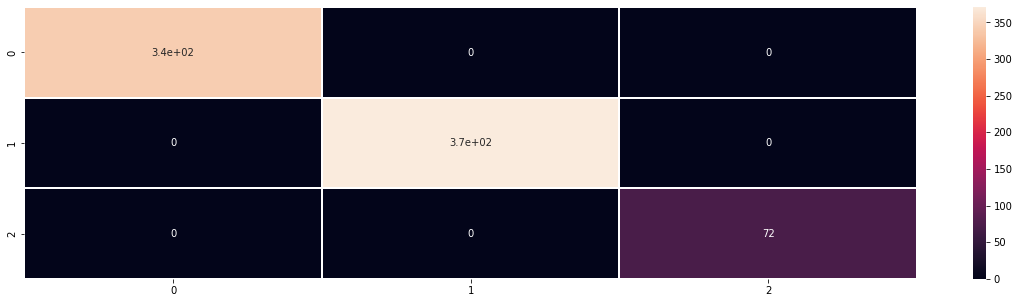

In [64]:
cm=confusion_matrix(y_test_new, pred)
fig, ax = plt.subplots(figsize=(20,5)) 
sns.heatmap(cm, annot=True, linewidths=2, ax=ax)

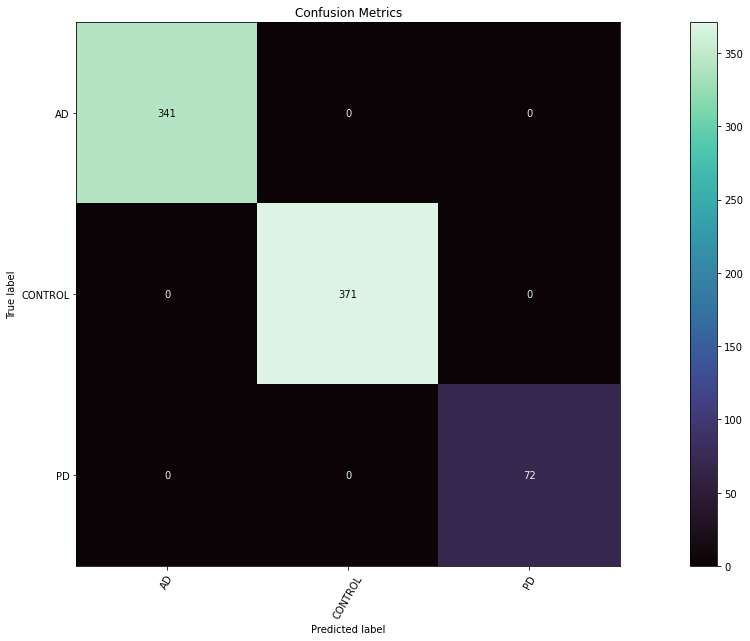

In [67]:
display_c_m = ConfusionMatrixDisplay(cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(25,10)) 
display_c_m.plot(cmap='mako',ax=ax,xticks_rotation=60)
plt.title("Confusion Metrics")
plt.show()

In [29]:
def accuracy_loss_plot (history):
    fig = plt.figure(figsize=(10,10))
    
    plt.subplot(221)
    plt.plot(history.history["accuracy"], 'bo--', label="accuracy")
    plt.plot(history.history['val_accuracy'], 'ro--', label="val_accuracy")
    plt.title("Training Data Accuracy Measurements")
    plt.xlabel("Number of epochs")
    plt.ylabel("Accuracy")
    plt.grid()
    plt.legend()
    plt.tight_layout()
    
    plt.subplot(222)
    plt.plot(history.history["loss"], "bo--", label="loss")
    plt.plot(history.history["val_loss"], "ro--", label = "val_loss")
    plt.title("Training Data Loss")
    plt.xlabel("Number of epochs")
    plt.ylabel("loss")
    plt.grid()
    plt.legend()
    plt.tight_layout()
    
    plt.show()

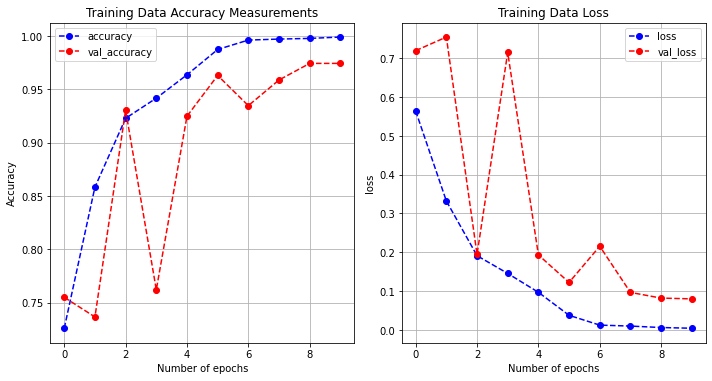

In [30]:
accuracy_loss_plot(history)

In [55]:
def imagePrediction(upload):
    for name, fileinfo  in uploader.value.items():
        image = Image.open(io.BytesIO(fileinfo['content']))
        
    images = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
    images = cv2.resize(images,(150, 150))
    images = images.reshape(1, 150, 150, 3)
    prd = model.predict(images)
    prd = np.argmax(prd, axis = 1)[0]
    
    
    if prd == 0:
        prd = "AD"
    elif prd == 1:
        prd = "CONTROL"
    elif prd ==2:
        prd = "PD"
        
    if prd!=1:
        print(f"Model Predict That is  a {prd}")

In [59]:
uploader = widgets.FileUpload()
display(uploader)

FileUpload(value={}, description='Upload')

In [60]:
button = widgets.Button(description="Predict")
out = widgets.Output()

def on_button_click(_): 
    with out:
        clear_output()
        try: 
            imagePrediction(uploader)
        except:
            print("Enter the correct image file")
button.on_click(on_button_click)
widgets.VBox([button, out])